In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares
import datetime as dt
import pandas as pd
from pprint import pprint
from scipy.interpolate import interp1d
import math

In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def DDPrice(F, K, r, sigma, T, beta, payoff):
    if (payoff.lower() == 'call'):
        DDCall(F, K, r, sigma, T, beta)
        
    elif (payoff.lower() == 'put'):
        DDPut(F, K, r, sigma, T, beta)
    else:
        raise NameError('Payoff type not recognized')

def DDCall(F, K, r, sigma, T, beta):
    if beta == 0:
        S = F*np.exp(-r*T)
        BlackScholesLognormalCall(S, K, r, sigma, T)
    else:
        BlackCall(F/beta, K+((1-beta)/beta)*F, r, sigma*beta, T)

def DDPut(F, K, r, sigma, T, beta):
    if beta == 0:
        S = F*np.exp(-r*T)
        BlackScholesLognormalPut(S, K, r, sigma, T)
    else:
        BlackPut(F/beta, K+((1-beta)/beta)*F, r, sigma*beta, T)

def BlackCall(F, K, r, sigma, T):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)* (F * norm.cdf(d1) - K*norm.cdf(d2))

def BlackPut(F, K, r, sigma, T):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)* (K * norm.cdf(-d2) - F*norm.cdf(-d1))

In [3]:
# SPX Dataset
spx_df =\
(
    pd
    .read_csv('SPX_options.csv')
)

# SPY Dataset
spy_df =\
(
    pd
    .read_csv("SPY_options.csv")
)

# Rates Dataset
rates_df =\
(
    pd
    .read_csv('zero_rates_20201201.csv')
)

In [4]:
# Project is to calculate on 1-Dec-2020
today =\
(
    dt
    .date(2020, # Year
          12,   # Month
          1)    # Date
)

# Since both datasets have same expiries, we would not be creating another one.
expiries =\
(
    [
        pd.Timestamp(str(x)).date() for x in spx_df['exdate'].unique()
    ]
)

# Time left till expiry
Time =\
(
    [
        (exdate - today).days/365.0 for exdate in expiries
    ]
)

# Calculate rates for each expiry date
days_to_expiry_list = []

for exp in expiries:
    days_to_expiry = (exp - today).days
    days_to_expiry_list.append(days_to_expiry)

zero_rate_curve =\
(
    interp1d(rates_df['days'], 
             rates_df['rate'])
)

rates =\
(
    [
        zero_rate_curve(days)/100 for days in days_to_expiry_list
    ]
)

exdates =\
(
    sorted(spx_df['exdate'].unique())
)

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\252290936.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\252290936.py:12: RuntimeW

Calibrated SABR model parameters for 20201218: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


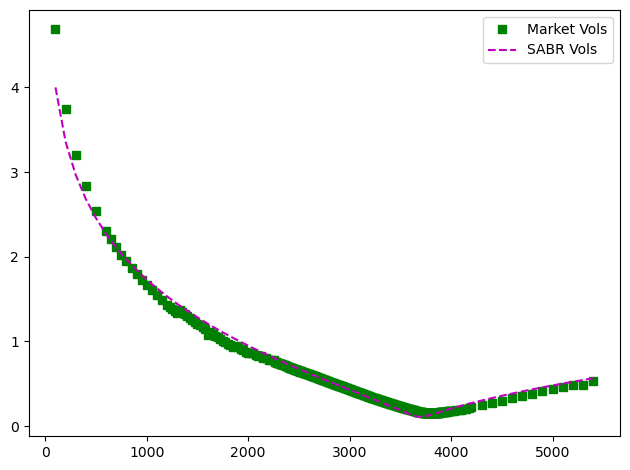

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\252290936.py:12: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\252290936.py:12: RuntimeWarning: i

Calibrated SABR model parameters for 20210115: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


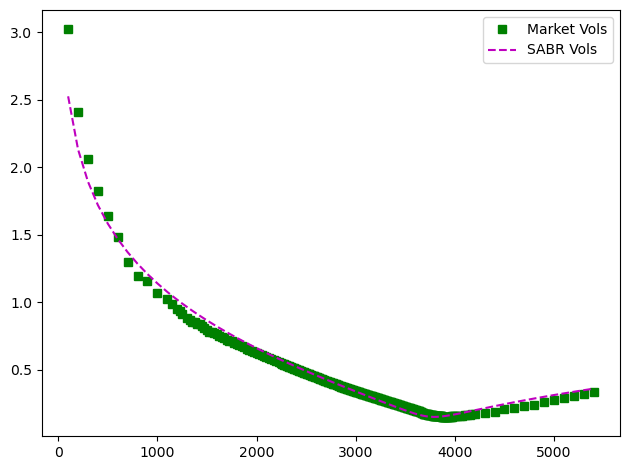

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\3639094832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Calibrated SABR model parameters for 20210219: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


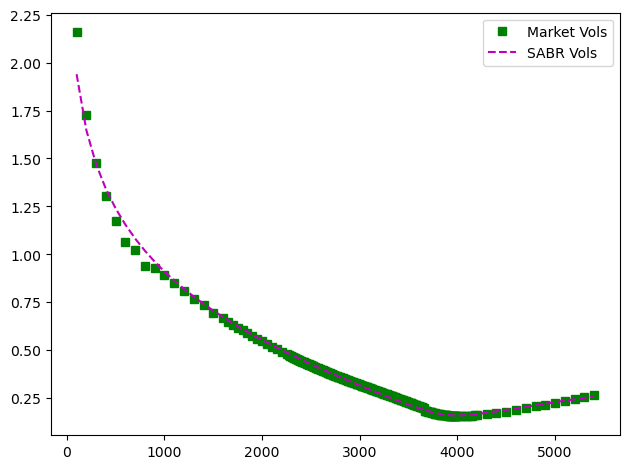

In [5]:
for (date, T, r) in zip(exdates, Time, rates):
    df = spx_df
    S = 3662.45
    F = S*np.exp(r*T)
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    df = df[df['exdate'] == date]
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    
    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(f'Calibrated SABR model parameters for {date}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')
    
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    plt.figure(tight_layout=True)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.legend()
    plt.show()

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Calibrated SABR model parameters for 20201218: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


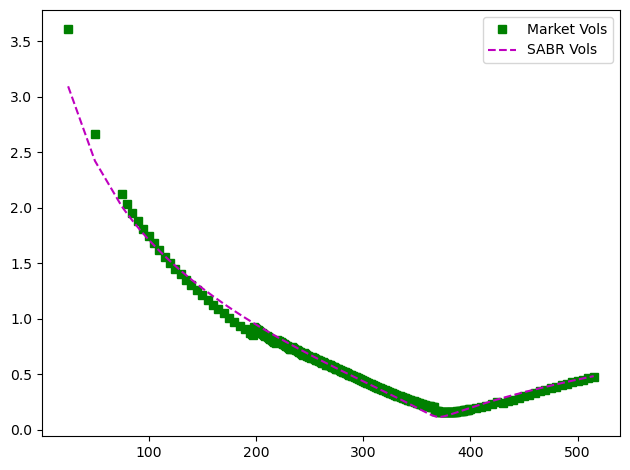

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Calibrated SABR model parameters for 20210115: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


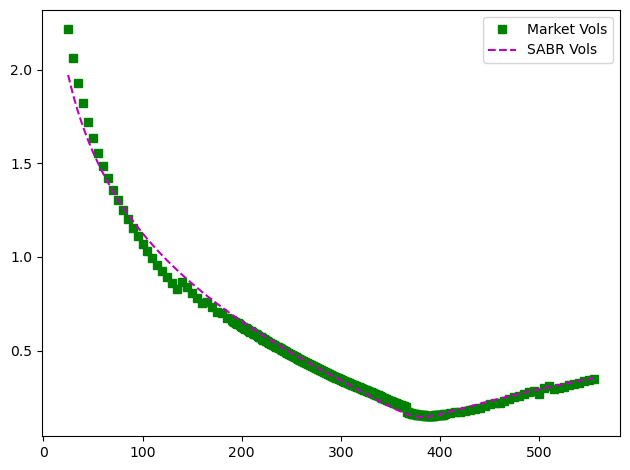

C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\794002624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\wweih\AppData\Local\Temp\ipykernel_18140\252290936.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters for 20210219: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


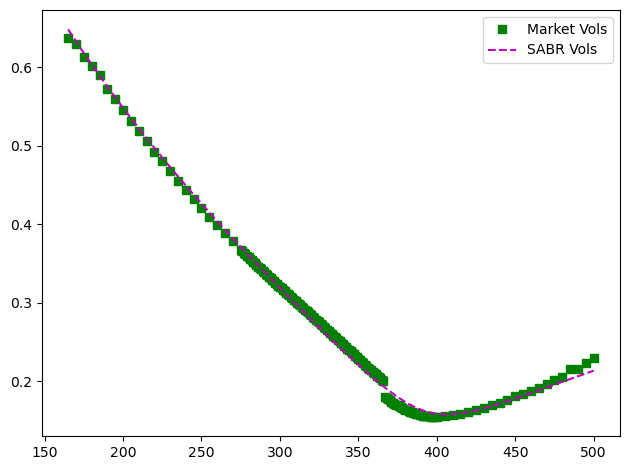

In [6]:
for (date, T, r) in list(zip(exdates, Time, rates)):
    df = spy_df
    S = 366.02
    F = S*np.exp(r*T)
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    df = df[df['exdate'] == date]
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    
    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(f'Calibrated SABR model parameters for {date}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')
    
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    plt.figure(tight_layout=True)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.legend()
    plt.show()